## Deep Learning In Physics - Nanoscience group.

Julian Bernat

Ilija Gjerapić

Dorus Harmsen

Project: symmetry classification of xrd spectra, see [this paper](https://www.nature.com/articles/s41524-019-0196-x). Please also refer to the original [autoXRD github repo](https://github.com/PV-Lab/autoXRD)

To run this code it is necessary to have it in the same directory as autoXRD.py and have the datasets in the Datasets folder inside this directory.


In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLP/DLP_autoXRD/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DLP/test/DLP_autoXRD


# Dependencies

In [2]:
# Loads series of functions for preprocessing and data augmentation
from autoXRD import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

# Neural networks uses Keran with TF background
import keras as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras


# Loading data

THeoretical data:

In [3]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
theor = theor.iloc[1:,]
theor_arr=theor.values

# Normalize data for training
ntheor = normdata(theor_arr)

# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

In [4]:
ntheor.shape

(2125, 164)

In [5]:
np.shape(label_theo)

(328,)

Experimental data:

In [4]:
# Load experimental data as dataframe
exp_arr_new = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr_new = exp_arr_new.values

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_exp.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

# Load class enconding
space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Normalize experimental data
nexp = normdata(exp_arr_new)

# Define spectral range for data augmentation
exp_min = 0
exp_max = 1200
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

In [7]:
theor_max

1325

In [8]:
ntheor.shape

(2125, 164)

# Data augmentation

Taking 50% of training and 50% of experimental as test, then using the remaining to augment

In [5]:
#####################################################################
####    Labeling Theoretical and Experimental Data
#####################################################################
###  theoretical ###
n_naug_theo = len(ntheor[0])
croped_theo = np.zeros([theor_max - theor_min, n_naug_theo])
y_theo = np.zeros(n_naug_theo)
for i in range(n_naug_theo):
    croped_theo[:, i] = ntheor[theor_min:theor_max, i]
    y_theo[i] = space_group_enc.index(label_theo[2 * i]) # label is there for both x and y, thus need steps of 2

# preparing for testing
X_theo = np.transpose(croped_theo)
y_theo = y_theo

# experimental
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]

#####################################################################
####    Splitting in half
#####################################################################

X_exp_test, X_exp_toAug, Y_exp_test, Y_exp_toAug = train_test_split(X_exp, y_exp, test_size=0.5, random_state=30)
X_theo_test, X_theo_toAug, Y_theo_test, Y_theo_toAug = train_test_split(X_theo, y_theo, test_size=0.5, random_state=30)


#####################################################################
####    Augmenting to have equal instances of each space group in Training
#####################################################################


# number of augmented data for each space group
aug_num = 400

# tmp_y_train = np.zeros([aug_num, len(np.unique(Y_exp_toAug))])
# tmp_x_train = np.zeros([aug_num, len(X_exp_toAug[0])])

tmp_exp_y_train = []
tmp_exp_x_train = []

tmp_theo_y_train = []
tmp_theo_x_train = []
for id in np.unique(Y_exp_toAug):
  # obtaining experimental spectra for each space group
  mask_exp = (Y_exp_toAug == id)
  X_exp_toAug_id = X_exp_toAug[mask_exp]
  Y_exp_toAug_id = Y_exp_toAug[mask_exp]

  # augmenting and appending data for experimental
  aug_x, aug_y = exp_augdata(X_exp_toAug_id.T, aug_num ,Y_exp_toAug_id.T)
  tmp_exp_x_train.append(aug_x.T)
  tmp_exp_y_train.append(aug_y.T)

  # obtaining theo spectra for each space group
  mask_theo = (Y_theo_toAug == id)
  X_theo_toAug_id = X_theo_toAug[mask_theo]
  Y_theo_toAug_id = Y_theo_toAug[mask_theo]

  # augmenting and storing data for theo
  # Use of exp_augdata(...) as data is already labelled
  aug_x, aug_y = exp_augdata(X_theo_toAug_id.T, aug_num ,Y_theo_toAug_id.T)
  tmp_theo_x_train.append(aug_x.T)
  tmp_theo_y_train.append(aug_y.T)

#####################################################################
####    Concatenating for separate experimental train and theo Train data
#####################################################################

exp_x_train = np.concatenate(tmp_exp_x_train, axis=0)
exp_y_train = np.concatenate(tmp_exp_y_train, axis=0)

theo_x_train = np.concatenate(tmp_theo_x_train, axis=0)
theo_y_train = np.concatenate(tmp_theo_y_train, axis=0)

In [6]:
#####################################################################
####    Concatenating for Final Test and Train data
#####################################################################
x_train = np.concatenate((exp_x_train, theo_x_train), axis=0)
y_train = np.concatenate((exp_y_train, theo_y_train), axis=0)
X_test = np.concatenate((X_exp_test, X_theo_test), axis=0)
y_test = np.concatenate((Y_exp_test, Y_theo_test), axis=0)

In [8]:
unique, counts = np.unique(y_train, return_counts=True)

data_train = {
    'Space group label': space_group_enc,
    'Counts in training dataset': counts
}

df_train = pd.DataFrame(data_train)

unique, counts = np.unique(y_test, return_counts=True)

data_test = {
    'Space group label': space_group_enc,
    'Counts in testing dataset': counts
}

df_test = pd.DataFrame(data_test)

Verifying sizes of train and test datasets

In [12]:
df_train

,Space group label,Counts in training dataset
0,Fm-3m,800
1,I41mcm,800
2,P21a,800
3,P3m1,800
4,P61mmc,800
5,Pc,800
6,Pm-3m,800


In [13]:
df_test

,Space group label,Counts in testing dataset
0,Fm-3m,37
1,I41mcm,16
2,P21a,12
3,P3m1,14
4,P61mmc,8
5,Pc,3
6,Pm-3m,36


# Visualization of data augmentation

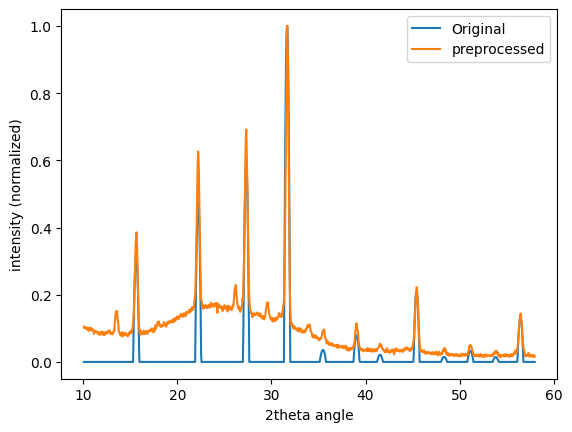

In [9]:
rnd = 0#np.random.randint(0,100)
demo_t = post_exp[exp_min:exp_max,(rnd)]
demo_x = exp_arr_new[exp_min:exp_max,0]
plt.plot(demo_x,post_exp[:, 0],label='Original')
plt.plot(demo_x,nexp[exp_min:exp_max, 0], label='preprocessed')
plt.ylabel('intensity (normalized)')
plt.xlabel('2theta angle')
plt.legend(loc='upper right')
plt.show()

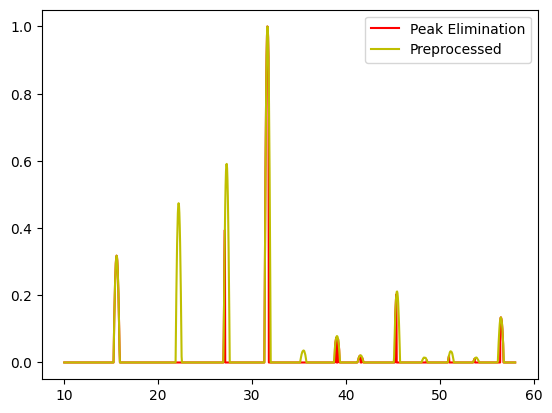

In [15]:
#add in the first filter (peak elimination)
dum1= np.repeat(np.random.choice([0,0,1],300),len(demo_x)//300)
demo_1st = np.multiply(demo_t,dum1)
#plot
plt.plot(demo_x,demo_1st,label='Peak Elimination', color= 'r')
plt.plot(demo_x, demo_t, label='Preprocessed', color='y')
plt.legend(loc='upper right')
plt.show()

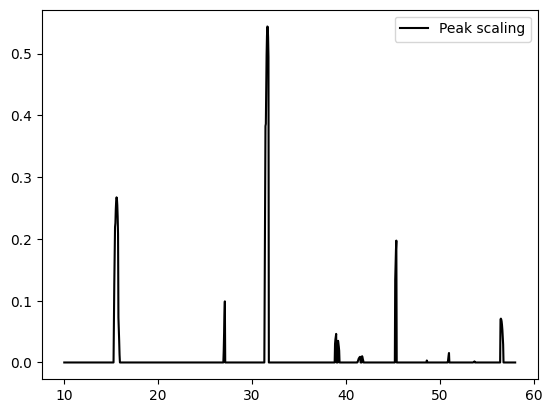

In [16]:
dum2= np.repeat(np.random.rand(150,),len(demo_x)//150)
demo_2nd = np.multiply( demo_1st,dum2)
#plot
plt.plot(demo_x,demo_2nd,label='Peak scaling', color= 'k')
plt.legend(loc='upper right')
plt.show()

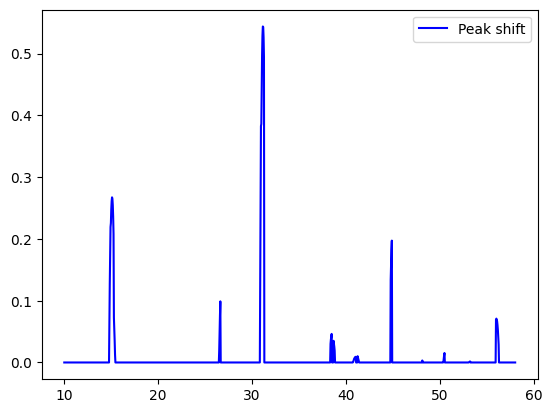

In [17]:
cut = np.random.randint(-20*1,20)
#XRD spectrum shift to left
if cut>=0:
    demo_3rd = np.append(demo_2nd[cut:,],np.zeros([cut,]))
#XRD spectrum shift to right
else:
    demo_3rd = np.append(demo_2nd[0:len(demo_x)+cut,],np.zeros([cut*-1,]))
#plot
plt.plot(demo_x,demo_3rd,label='Peak shift', color= 'b')
plt.legend(loc='upper right')
plt.show()

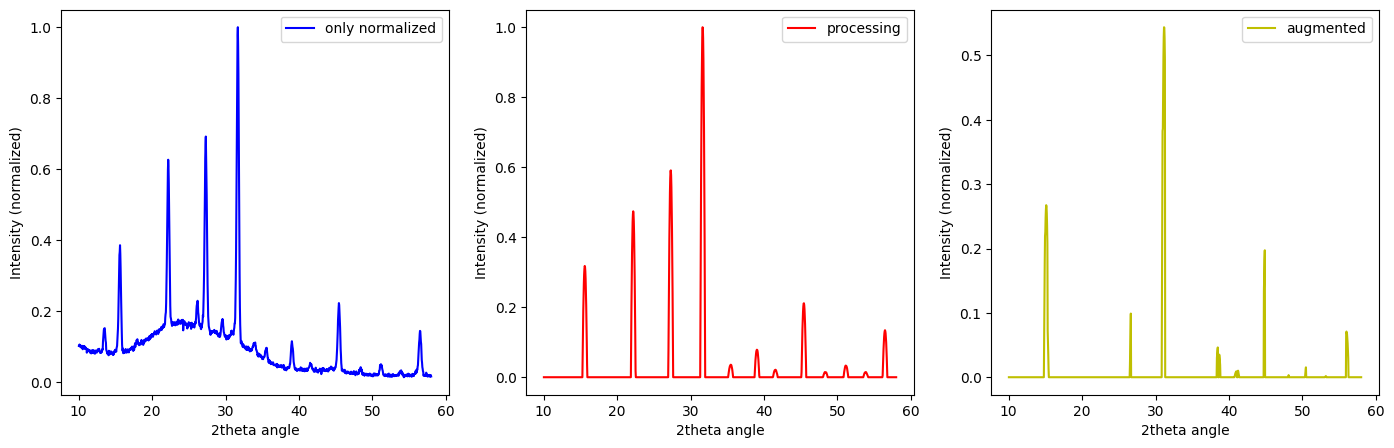

In [18]:
#plotting all three spectra next to each other.
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(demo_x, nexp[exp_min:exp_max, 0], label='only normalized', color='b')
axs[1].plot(demo_x, post_exp[:, 0], label='processing', color='r')
axs[2].plot(demo_x, demo_3rd, label='augmented', color='y')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_ylabel('Intensity (normalized)')
axs[1].set_ylabel('Intensity (normalized)')
axs[2].set_ylabel('Intensity (normalized)')
axs[0].set_xlabel('2theta angle')
axs[1].set_xlabel('2theta angle')
axs[2].set_xlabel('2theta angle')
plt.show()
fig.tight_layout()

# Data preparation

In [7]:
def data_prep():
    enc = OneHotEncoder()

    train_dim = x_train.reshape(x_train.shape[0],1200,1)
    train_y = y_train
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1)).toarray()  # Convert to dense array

    # Define test data
    test_x = X_test.reshape(X_test.shape[0],1200,1)
    test_y = enc.fit_transform(y_test.reshape(-1,1)).toarray()

    if isinstance(train_y_hot, tf.sparse.SparseTensor):
        train_y_hot = tf.sparse.to_dense(train_y_hot)

    return train_dim, train_y_hot, test_x, test_y

train_x, train_y, test_x, test_y = data_prep()


# Defining different models

below you can write a function where we define specific models which can be loaded, evaluated and for which we can plot a confusion matrix

## CNN model

In [11]:

# Define network structure
def a_cnn_model(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## Original CNN model with Categorical Cross-Entropy Loss

In [12]:
# Define network structure
def a_cnn_model_cat_loss(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN model but with L1 regularization in each Conv1D layer

In [13]:

# Define network structure
def a_cnn_model_reg(X_training, train_y_hot, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1),
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## paper CNN but with more features for lower levels

In [14]:
# Define network structure
def a_cnn_model_features(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(64, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(128, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN with more layers (2 more layers)
* added one Conv1D with 5 strides and one with 3 strides

In [15]:
# Define network structure
def cnn_model_layers(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN model with batchnorm

I experimented with a CNN model which has batchnorm but I found that only 1 batchnorm layer works the best

In [16]:

# Define network structure
def batchnorm_model(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN with batchnorm with a different optimizer

In [17]:

# Define network structure
def batchnorm_model_sgd(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.SGD(learning_rate = 0.1, momentum=0.01)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN big model

In [18]:
def cnn_model_big(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 10
    kernel_size = 2

    model = Sequential()

    model.add(K.layers.Conv1D(64, 8 ,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(48, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(64, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Dropout(0.1))
    model.add(K.layers.Conv1D(48, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam(learning_rate = 0.001)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## Decision tree

In [19]:
import xgboost as xgb
def decision_tree(X_training, y_training, rounds):

    # Convert one-hot encoding to class indices
    #have to convert one hot back to indices
    y_train = np.argmax(y_training, axis=1)
    x_training = X_training.reshape(X_training.shape[0], -1)
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(x_training, label=y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters for multiclass classification
    params = {
        "objective": "multi:softmax",  # Multi-class classification
        "num_class": 7,  # Number of classes
        "eval_metric": "mlogloss",  # Multi-class log loss
    }

    # Train the model
    num_round = rounds  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_round)

    return model

# Functions to evaluate the models

## Confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(model):
    prediction = model.predict(test_x)
    # For a classification task, convert predictions to class labels (if needed)
    prediction_ord=[np.argmax(element) for element in prediction]


    # If your true labels are one-hot encoded, you may need to convert them as well
    true_labels = [np.argmax(element) for element in test_y]

    cm = confusion_matrix(true_labels, prediction_ord, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()
    return None

## ROC Curves

Using ROC to evaluate multiple classes requires more consideration.
We have used the one-vs-rest (OVR) stategy, which is also refered to as the one-vs-all strategy. In this method, the ROC for each class is determined where a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

We consider both the micro-averaging and macro-averaging.

In micro-averaged OvR, the average metrics are computed as:
$$ TPR = \frac{\sum_CTP_C}{\sum_C(TP_C + FN_C)};$$
$$ FPR = \frac{\sum_CFP_C}{\sum_C(FP_C + TN_C)}.$$
Mainly, the contributions from all the classes are considered. Note, this is usefull for highly imbalanced classes as not all classses are treated equally prior to the calculation.

For macro-averaging, the metrics are computed independently for each class and then taking the average over them.
$$ TPR = \frac{1}{C}\sum_C\frac{TP_C}{TP_C + FN_C};$$
$$ FPR = \frac{1}{C}\sum_C\frac{FP_C}{FP_C + TN_C}.$$

In [9]:
from sklearn.metrics import roc_curve, auc

def plot_roc_OVR(model, test_x, test_y, X_test=None):
  """
  Determines and plots the ROC for the class vs rest classification.
  """
  prediction = model.predict(test_x)

  n_classes = len(np.unique(label_theo))

  # Compute ROC curve and AUC for each class
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # ROC for each class
  for i in range(n_classes):  # 7 classes
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], prediction[:, i])
      roc_auc[i]= auc(fpr[i], tpr[i])


  # Micro-average ROC curve and AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), prediction.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and AUC
  fpr_grid = np.linspace(0.0 , 1.0, 1000)

  # linear interpolate all ROC curves at the points
  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

  # average it and then compute macros AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot ROC for each class
  colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
  for i, color in enumerate(colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{space_group_enc[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro and macro average ROC curves
  plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc["micro"]:.2f})', lw=2)
  plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='gray',
           label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()


## Classification Report

In [10]:
def class_report(model, test_x, test_y):
  """
  Outputs a summary of the classification for a model and test data.
  Includes the precision, recall, f1-score and support for each class.
  Along with the accuracy and macro average and weighted average.
  """
  prediction = model.predict(test_x)
  prediction_ord=[np.argmax(element) for element in prediction]


  # If your true labels are one-hot encoded, you may need to convert them as well
  true_labels = [np.argmax(element) for element in test_y]

  df  = classification_report(true_labels, prediction_ord, digits=4, output_dict=True)
  print(classification_report(true_labels, prediction_ord, digits=4))

  return df

## Plotting Accuracy for training and validation

In [11]:
def plot_acc(hist):
  """
  Plots the accuracy for the training and validation data over epochs
  """
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [12]:
def eval_model(model, hist, test_x, test_y):
  """
  Combines all the functions to evaluate a model
  """
  model.summary()
  plot_acc(hist)
  conf_matrix(model)
  plot_roc_OVR(model, test_x, test_y)
  class_report(model, test_x, test_y)
  print(model.evaluate(test_x, test_y, return_dict = True))

# Training and evaluating different models

## Original CNN

In [34]:
cnn_model, cnn_hist = a_cnn_model(train_x, train_y, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - categorical_accuracy: 0.1447 - loss: 0.6512 - val_categorical_accuracy: 0.0952 - val_loss: 0.4670
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.1753 - loss: 0.4178 - val_categorical_accuracy: 0.1667 - val_loss: 0.4096
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2944 - loss: 0.4035 - val_categorical_accuracy: 0.1587 - val_loss: 0.4050
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4075 - loss: 0.3843 - val_categorical_accuracy: 0.1746 - val_loss: 0.4303
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4223 - loss: 0.3501 - val_categorical_accuracy: 0.1746 - val_loss: 0.4563
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4447 - loss: 0.3361 - val_categorical_accuracy: 0.1825 - val_loss: 0.4657
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4784 - loss: 0.3

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

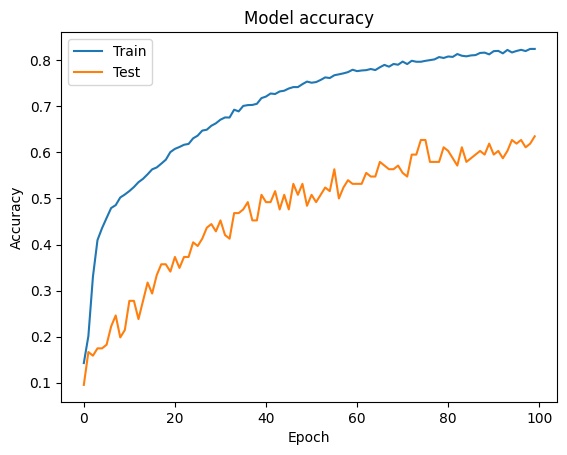

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


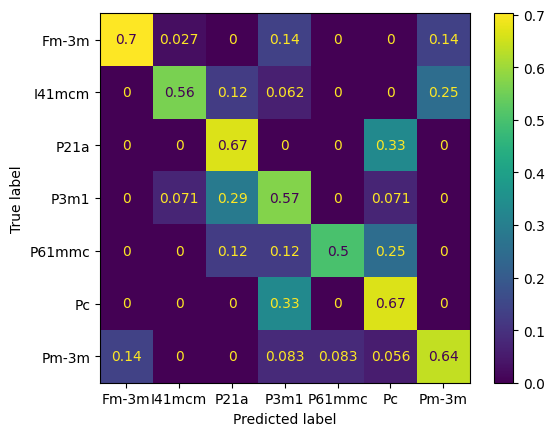

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


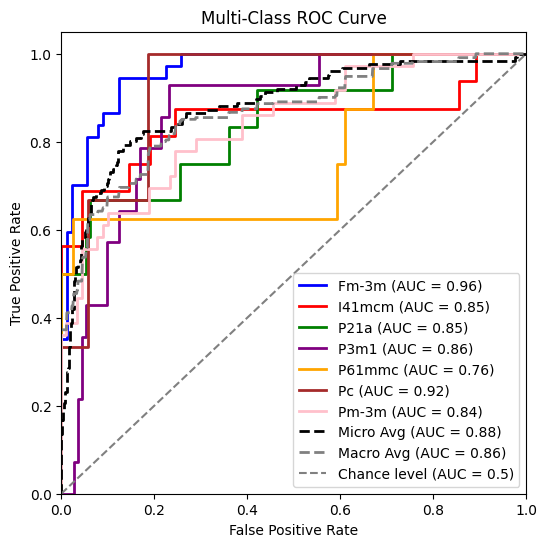

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0     0.8387    0.7027    0.7647        37
           1     0.8182    0.5625    0.6667        16
           2     0.5333    0.6667    0.5926        12
           3     0.4211    0.5714    0.4848        14
           4     0.5714    0.5000    0.5333         8
           5     0.1818    0.6667    0.2857         3
           6     0.7188    0.6389    0.6765        36

    accuracy                         0.6349       126
   macro avg     0.5833    0.6156    0.5720       126
weighted avg     0.6937    0.6349    0.6535       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - categorical_accuracy: 0.6248 - loss: 0.4870
{'categorical_accuracy': 0.6349206566810608, 'loss': 0.48089927434921265}


In [35]:
eval_model(cnn_model, cnn_hist, test_x, test_y)

## Original CNN with Categorical cross-entropy

In [36]:
cnn_cat_model, cnn_cat_hist = a_cnn_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - categorical_accuracy: 0.1291 - loss: 0.6773 - val_categorical_accuracy: 0.2937 - val_loss: 0.4865
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.1514 - loss: 0.4354 - val_categorical_accuracy: 0.2857 - val_loss: 0.4074
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.1961 - loss: 0.4076 - val_categorical_accuracy: 0.2460 - val_loss: 0.4021
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2706 - loss: 0.4004 - val_categorical_accuracy: 0.2460 - val_loss: 0.3972
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.3053 - loss: 0.3820 - val_categorical_accuracy: 0.2063 - val_loss: 0.4028
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4134 - loss: 0.3550 - val_categorical_accuracy: 0.1667 - val_loss: 0.4366
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4485 - loss: 0.3329 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

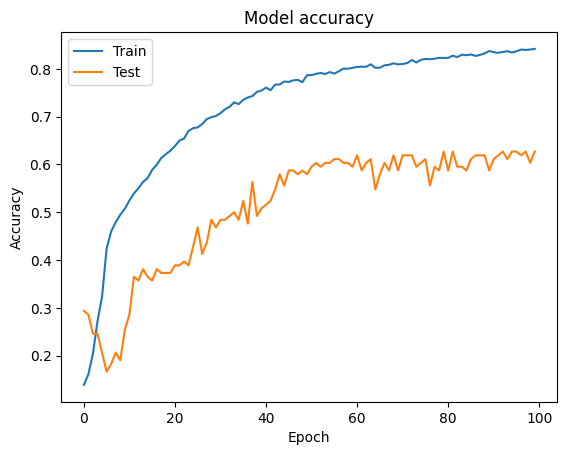

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


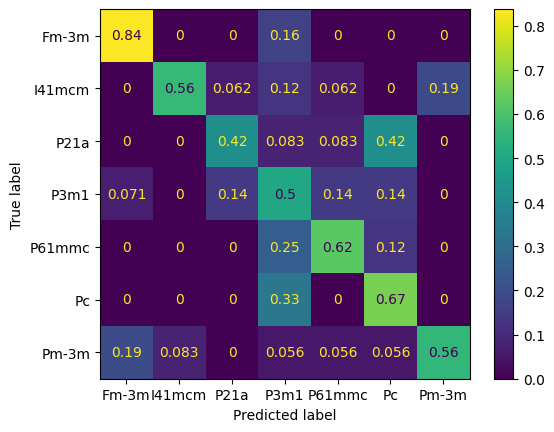

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


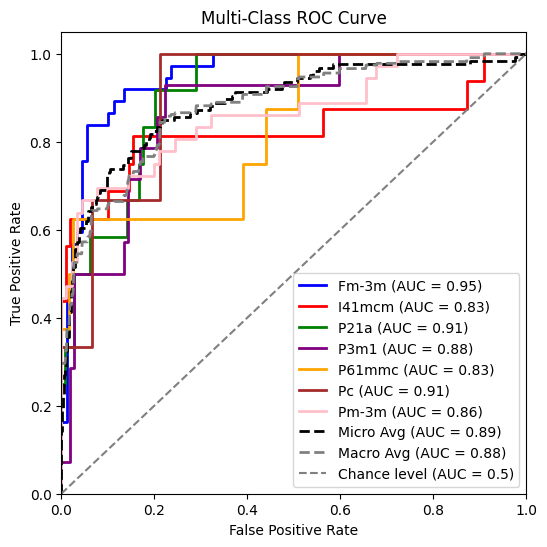

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0     0.7949    0.8378    0.8158        37
           1     0.7500    0.5625    0.6429        16
           2     0.6250    0.4167    0.5000        12
           3     0.3333    0.5000    0.4000        14
           4     0.4545    0.6250    0.5263         8
           5     0.1667    0.6667    0.2667         3
           6     0.8696    0.5556    0.6780        36

    accuracy                         0.6270       126
   macro avg     0.5706    0.5949    0.5471       126
weighted avg     0.7065    0.6270    0.6467       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_accuracy: 0.6039 - loss: 0.5023
{'categorical_accuracy': 0.6269841194152832, 'loss': 0.48494580388069153}


In [37]:
eval_model(cnn_cat_model, cnn_cat_hist, test_x, test_y)

## CNN with regulariztion


In [38]:
cnn_reg_model, cnn_reg_hist = a_cnn_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - categorical_accuracy: 0.1559 - loss: 0.6510 - val_categorical_accuracy: 0.2937 - val_loss: 0.4153
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.1522 - loss: 0.4199 - val_categorical_accuracy: 0.1190 - val_loss: 0.4136
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.2736 - loss: 0.4065 - val_categorical_accuracy: 0.1825 - val_loss: 0.4035
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3785 - loss: 0.3896 - val_categorical_accuracy: 0.1587 - val_loss: 0.3936
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4229 - loss: 0.3561 - val_categorical_accuracy: 0.1825 - val_loss: 0.4369
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4450 - loss: 0.3370 - val_categorical_accuracy: 0.1984 - val_loss: 0.4339
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.4940 - loss: 0.3218 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

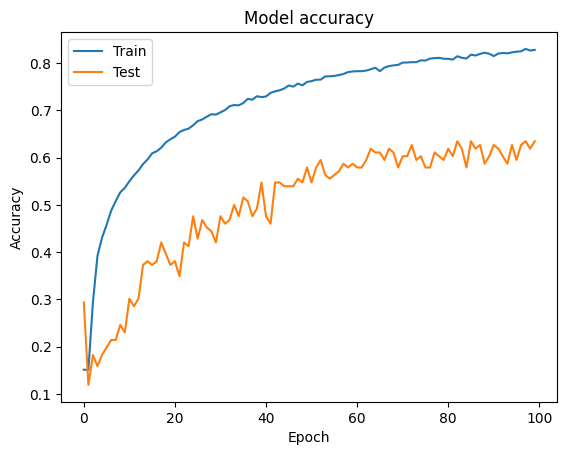

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


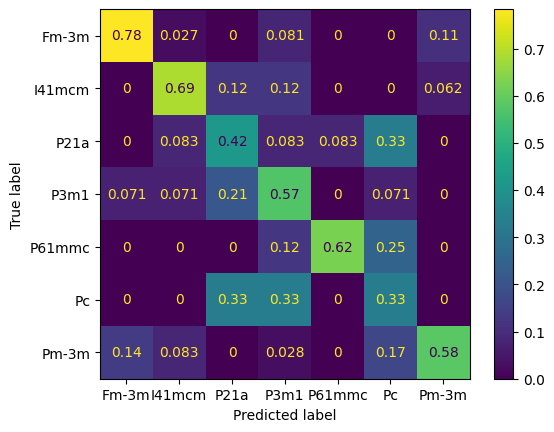

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


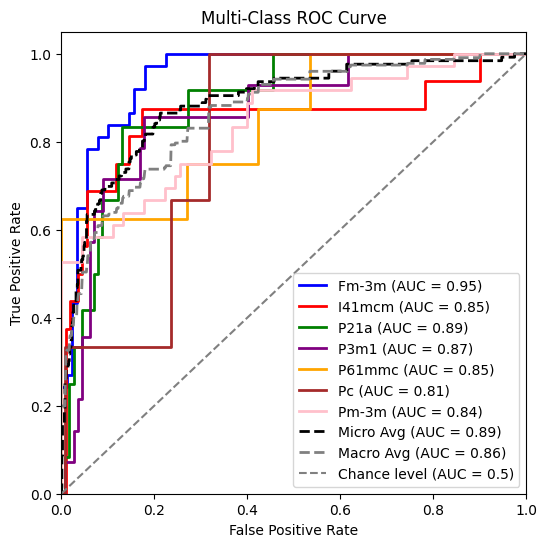

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0     0.8286    0.7838    0.8056        37
           1     0.6471    0.6875    0.6667        16
           2     0.4545    0.4167    0.4348        12
           3     0.4706    0.5714    0.5161        14
           4     0.8333    0.6250    0.7143         8
           5     0.0714    0.3333    0.1176         3
           6     0.8077    0.5833    0.6774        36

    accuracy                         0.6349       126
   macro avg     0.5876    0.5716    0.5618       126
weighted avg     0.7064    0.6349    0.6617       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - categorical_accuracy: 0.6290 - loss: 0.4566
{'categorical_accuracy': 0.6349206566810608, 'loss': 0.4609619677066803}


In [39]:
eval_model(cnn_reg_model, cnn_reg_hist, test_x, test_y)

## CNN with batchnorm

In [40]:
cnn_batchnorm_model, batchnorm_hist = batchnorm_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - categorical_accuracy: 0.2235 - loss: 1.8884 - val_categorical_accuracy: 0.2540 - val_loss: 1.9049
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5041 - loss: 1.4047 - val_categorical_accuracy: 0.2381 - val_loss: 1.8609
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5623 - loss: 1.1990 - val_categorical_accuracy: 0.0952 - val_loss: 2.0450
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6127 - loss: 1.0543 - val_categorical_accuracy: 0.0952 - val_loss: 2.3390
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6562 - loss: 0.9413 - val_categorical_accuracy: 0.0952 - val_loss: 2.5640
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6976 - loss: 0.8590 - val_categorical_accuracy: 0.0794 - val_loss: 2.7660
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7123 - loss: 0.7906 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,583 (103.84 KB)

 Trainable params: 8,839 (34.53 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 17,680 (69.07 KB)

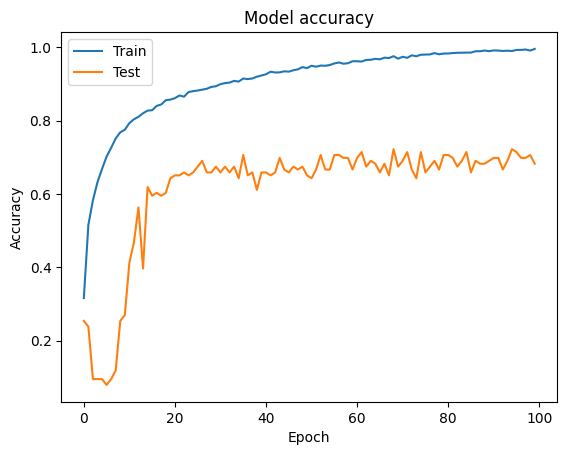

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


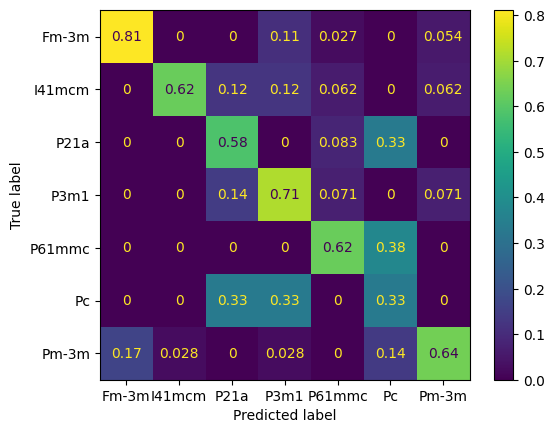

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


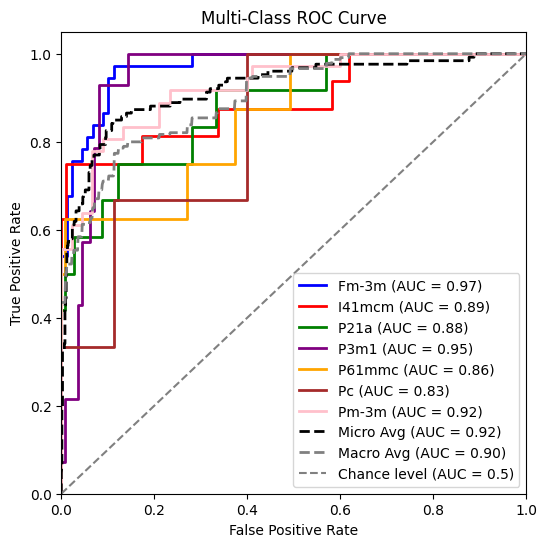

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.8333    0.8108    0.8219        37
           1     0.9091    0.6250    0.7407        16
           2     0.5833    0.5833    0.5833        12
           3     0.5556    0.7143    0.6250        14
           4     0.5556    0.6250    0.5882         8
           5     0.0769    0.3333    0.1250         3
           6     0.8519    0.6389    0.7302        36

    accuracy                         0.6825       126
   macro avg     0.6237    0.6187    0.6021       126
weighted avg     0.7579    0.6825    0.7094       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - categorical_accuracy: 0.6720 - loss: 3.2676
{'categorical_accuracy': 0.682539701461792, 'loss': 3.030346155166626}


In [41]:
eval_model(cnn_batchnorm_model, batchnorm_hist, test_x, test_y)

## CNN batchnorm with SGD

In [42]:
sgd_cnn, sgd_hist = batchnorm_model_sgd(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - categorical_accuracy: 0.2974 - loss: 1.8886 - val_categorical_accuracy: 0.0476 - val_loss: 1.9463
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4306 - loss: 1.5978 - val_categorical_accuracy: 0.0952 - val_loss: 1.9755
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4901 - loss: 1.3988 - val_categorical_accuracy: 0.0238 - val_loss: 2.2355
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5189 - loss: 1.2787 - val_categorical_accuracy: 0.0714 - val_loss: 2.7248
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5657 - loss: 1.1859 - val_categorical_accuracy: 0.0952 - val_loss: 2.8745
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5893 - loss: 1.1311 - val_categorical_accuracy: 0.0873 - val_loss: 3.1079
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6055 - loss: 1.0920 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,744 (69.32 KB)

 Trainable params: 8,839 (34.53 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 8,841 (34.54 KB)

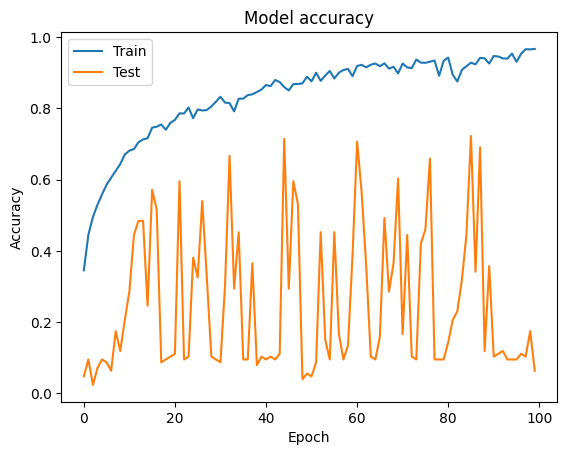

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


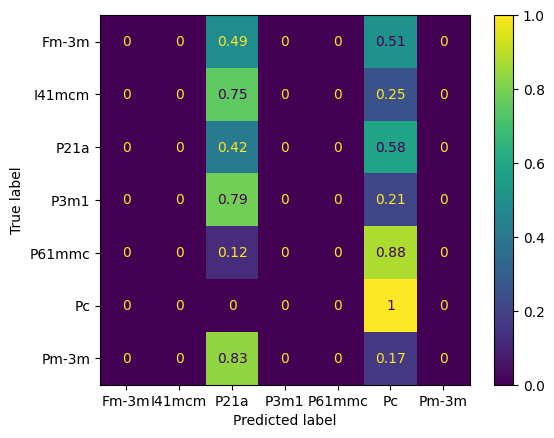

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


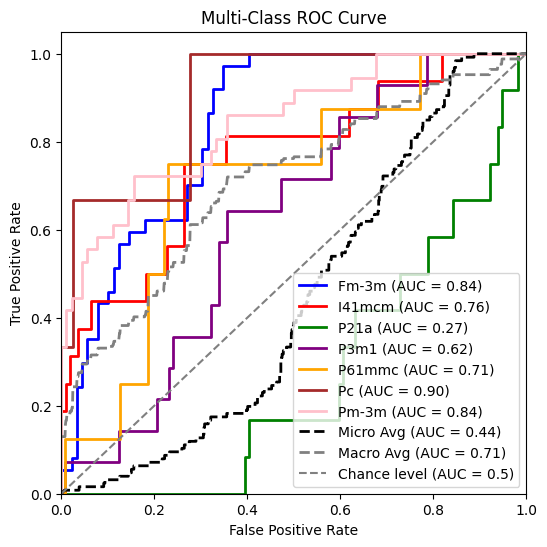

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        37
           1     0.0000    0.0000    0.0000        16
           2     0.0649    0.4167    0.1124        12
           3     0.0000    0.0000    0.0000        14
           4     0.0000    0.0000    0.0000         8
           5     0.0612    1.0000    0.1154         3
           6     0.0000    0.0000    0.0000        36

    accuracy                         0.0635       126
   macro avg     0.0180    0.2024    0.0325       126
weighted avg     0.0076    0.0635    0.0134       126



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.0514 - loss: 29.3417
{'categorical_accuracy': 0.0634920671582222, 'loss': 31.233692169189453}


In [43]:
eval_model(sgd_cnn, sgd_hist, test_x, test_y)

## CNN with more conv1D layers

In [44]:
layers_cnn, layers_hist = cnn_model_layers(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - categorical_accuracy: 0.2248 - loss: 1.9321 - val_categorical_accuracy: 0.2778 - val_loss: 1.7679
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5498 - loss: 1.3918 - val_categorical_accuracy: 0.3651 - val_loss: 1.4682
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7112 - loss: 0.7603 - val_categorical_accuracy: 0.5794 - val_loss: 1.2804
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8212 - loss: 0.5080 - val_categorical_accuracy: 0.6667 - val_loss: 1.4382
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.8740 - loss: 0.3608 - val_categorical_accuracy: 0.6667 - val_loss: 1.6484
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.8994 - loss: 0.2964 - val_categorical_accuracy: 0.7063 - val_loss: 1.7925
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.9240 - loss: 0.2189 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 32)               │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 1, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,095 (199.59 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,064 (133.07 KB)

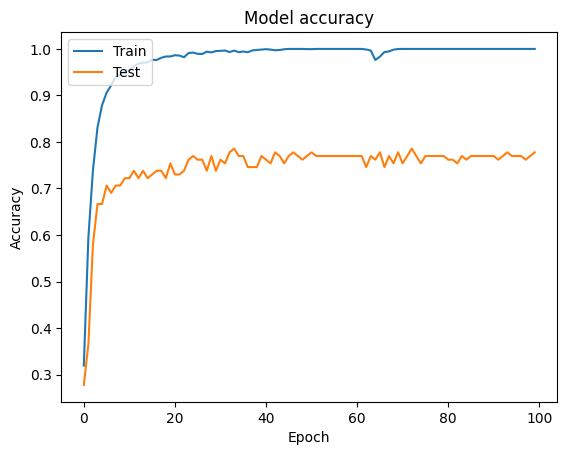

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


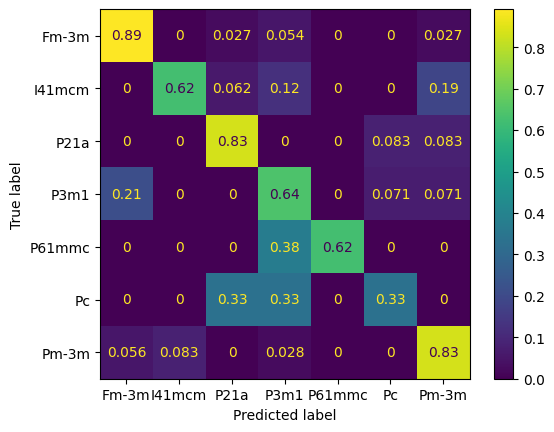

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


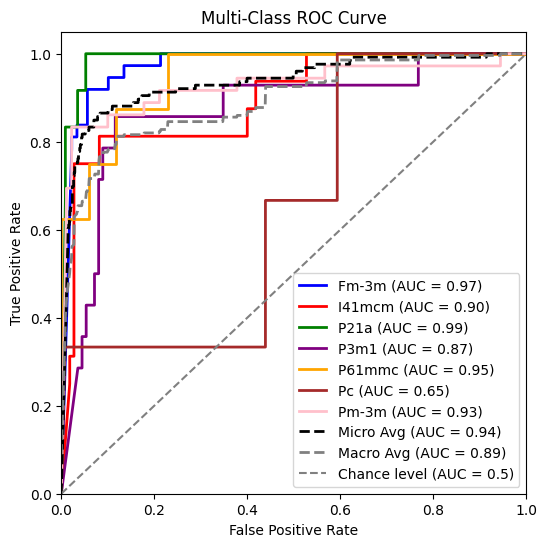

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0     0.8684    0.8919    0.8800        37
           1     0.7692    0.6250    0.6897        16
           2     0.7692    0.8333    0.8000        12
           3     0.5000    0.6429    0.5625        14
           4     1.0000    0.6250    0.7692         8
           5     0.3333    0.3333    0.3333         3
           6     0.8333    0.8333    0.8333        36

    accuracy                         0.7778       126
   macro avg     0.7248    0.6835    0.6954       126
weighted avg     0.7910    0.7778    0.7796       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - categorical_accuracy: 0.7611 - loss: 6.8604
{'categorical_accuracy': 0.7777777910232544, 'loss': 5.95986795425415}


In [45]:
eval_model(layers_cnn, layers_hist, test_x, test_y)

## CNN with different num of features

In [46]:
feat_cnn, feat_hist = a_cnn_model_features(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.2276 - loss: 1.9313 - val_categorical_accuracy: 0.1746 - val_loss: 1.8294
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4244 - loss: 1.5757 - val_categorical_accuracy: 0.2222 - val_loss: 2.3052
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5162 - loss: 1.3024 - val_categorical_accuracy: 0.3413 - val_loss: 1.9405
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5518 - loss: 1.1926 - val_categorical_accuracy: 0.3492 - val_loss: 2.1158
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5799 - loss: 1.1458 - val_categorical_accuracy: 0.3651 - val_loss: 2.1395
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6030 - loss: 1.0623 - val_categorical_accuracy: 0.3571 - val_loss: 2.1098
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6104 - loss: 1.0298 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,599 (424.22 KB)

 Trainable params: 36,199 (141.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,400 (282.82 KB)

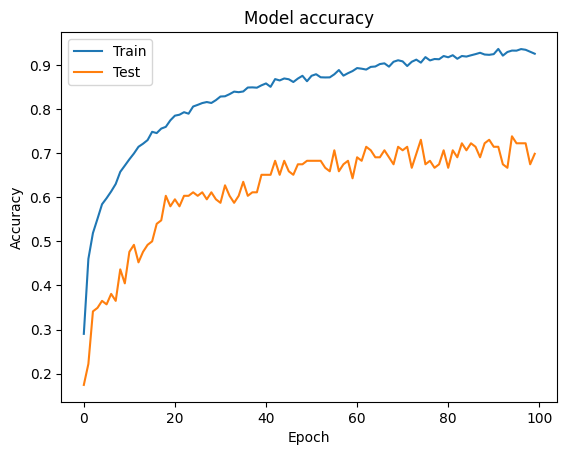

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


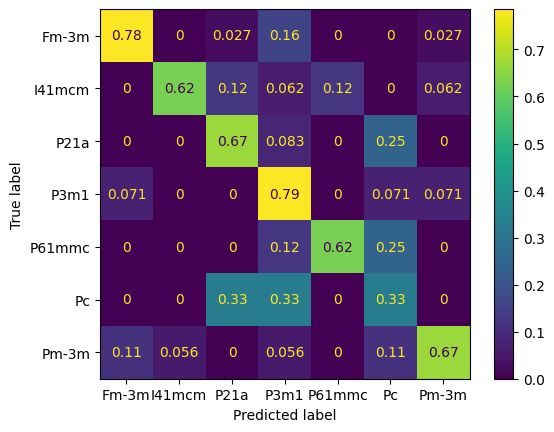

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


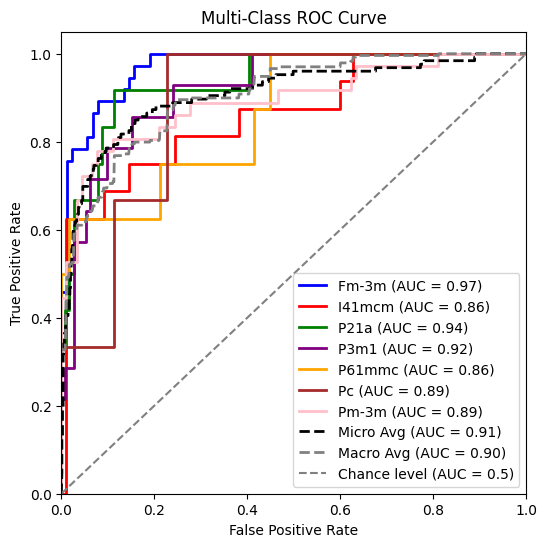

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0     0.8529    0.7838    0.8169        37
           1     0.8333    0.6250    0.7143        16
           2     0.6667    0.6667    0.6667        12
           3     0.4783    0.7857    0.5946        14
           4     0.7143    0.6250    0.6667         8
           5     0.0909    0.3333    0.1429         3
           6     0.8889    0.6667    0.7619        36

    accuracy                         0.6984       126
   macro avg     0.6465    0.6409    0.6234       126
weighted avg     0.7744    0.6984    0.7236       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - categorical_accuracy: 0.6773 - loss: 3.4595
{'categorical_accuracy': 0.6984127163887024, 'loss': 3.0514485836029053}


In [47]:
eval_model(feat_cnn, feat_hist, test_x, test_y)

##Big model

In [50]:
big_cnn, big_hist = cnn_model_big(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - categorical_accuracy: 0.3676 - loss: 1.7603 - val_categorical_accuracy: 0.2698 - val_loss: 1.8643
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7358 - loss: 0.7646 - val_categorical_accuracy: 0.1270 - val_loss: 2.5420
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8684 - loss: 0.3785 - val_categorical_accuracy: 0.0952 - val_loss: 3.5224
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9157 - loss: 0.2388 - val_categorical_accuracy: 0.0952 - val_loss: 3.9575
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9353 - loss: 0.1762 - val_categorical_accuracy: 0.0952 - val_loss: 4.9490
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9607 - loss: 0.1146 - val_categorical_accuracy: 0.0952 - val_loss: 4.7486
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9667 - loss: 0.0998 - val_ca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 64)             │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 48)              │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 64)               │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 2, 48)               │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 48)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,687 (405.03 KB)

 Trainable params: 34,519 (134.84 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 69,040 (269.69 KB)

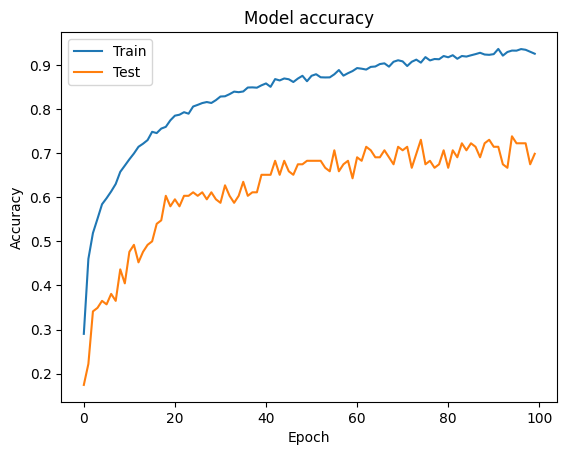

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


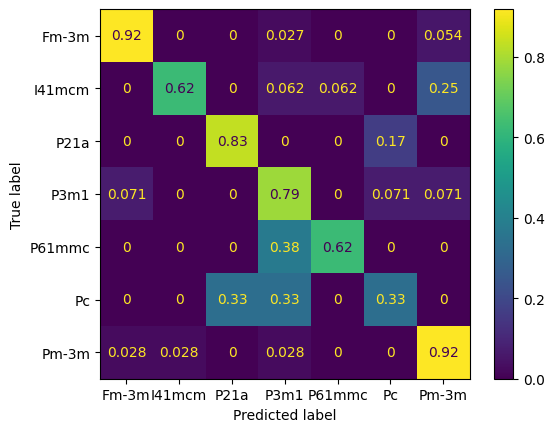

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


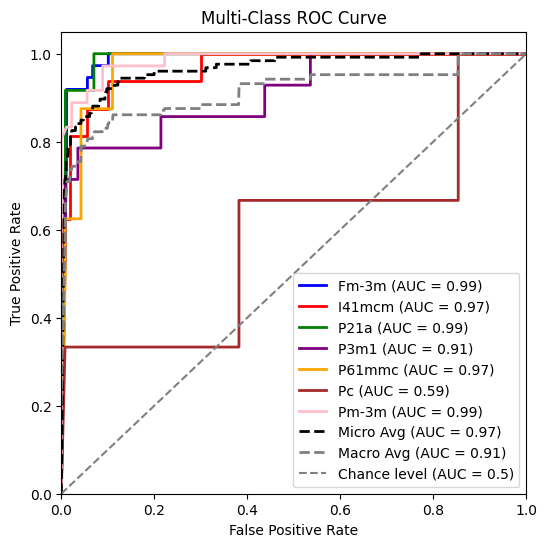

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.9444    0.9189    0.9315        37
           1     0.9091    0.6250    0.7407        16
           2     0.9091    0.8333    0.8696        12
           3     0.6111    0.7857    0.6875        14
           4     0.8333    0.6250    0.7143         8
           5     0.2500    0.3333    0.2857         3
           6     0.8250    0.9167    0.8684        36

    accuracy                         0.8254       126
   macro avg     0.7546    0.7197    0.7282       126
weighted avg     0.8418    0.8254    0.8271       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - categorical_accuracy: 0.7937 - loss: 3.8665
{'categorical_accuracy': 0.8253968358039856, 'loss': 3.4102225303649902}


In [51]:
eval_model(big_cnn, feat_hist, test_x, test_y)

## Decision Tree

[  2   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


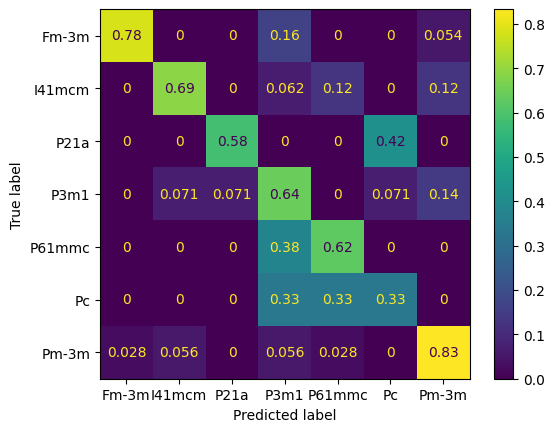

Accuracy: 0.7301587301587301


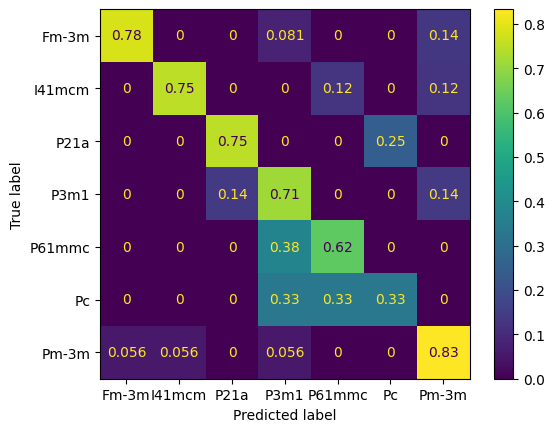

Accuracy: 0.7619047619047619


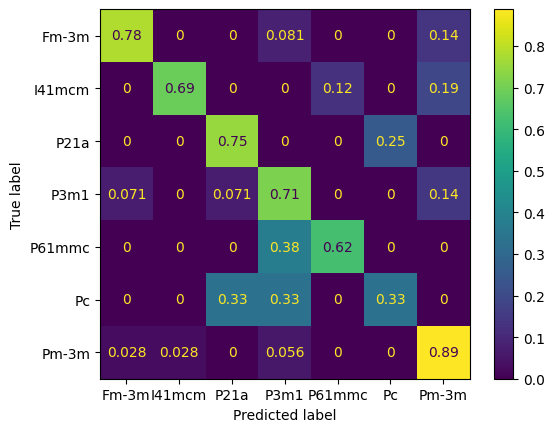

Accuracy: 0.7698412698412699


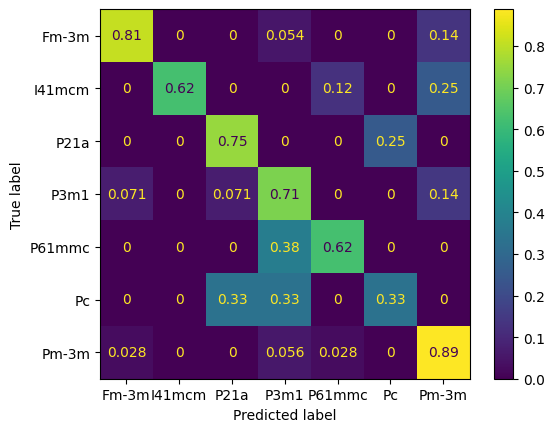

Accuracy: 0.7698412698412699


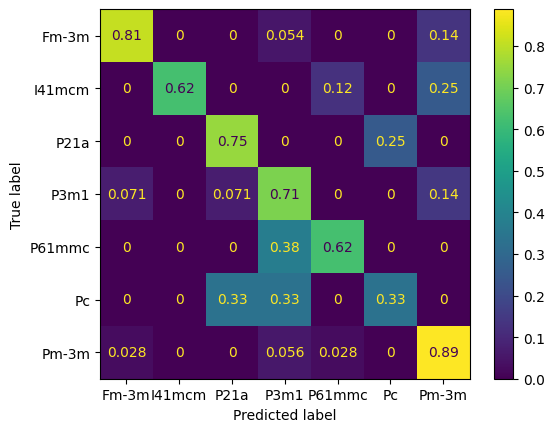

Accuracy: 0.7698412698412699


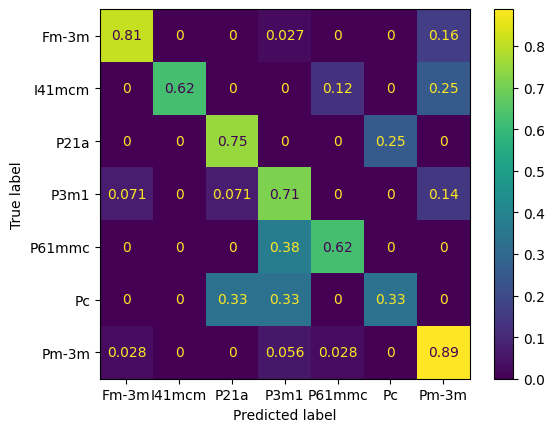

Accuracy: 0.7698412698412699


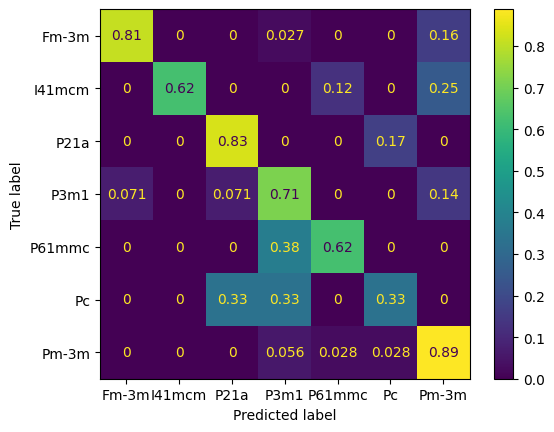

Accuracy: 0.7777777777777778


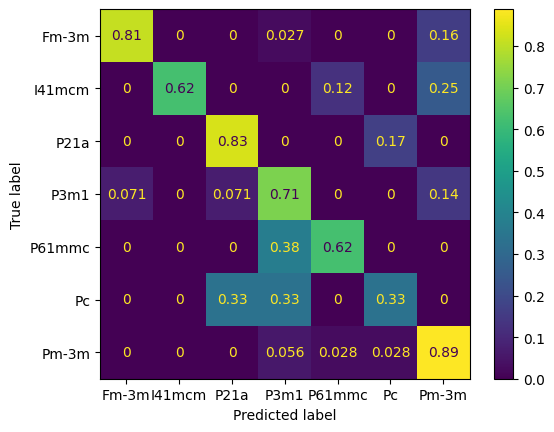

Accuracy: 0.7777777777777778


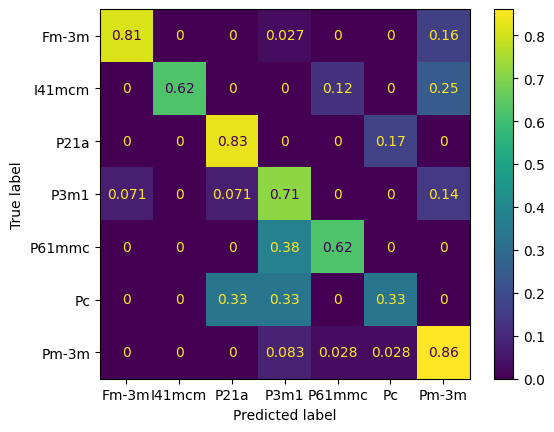

Accuracy: 0.7698412698412699


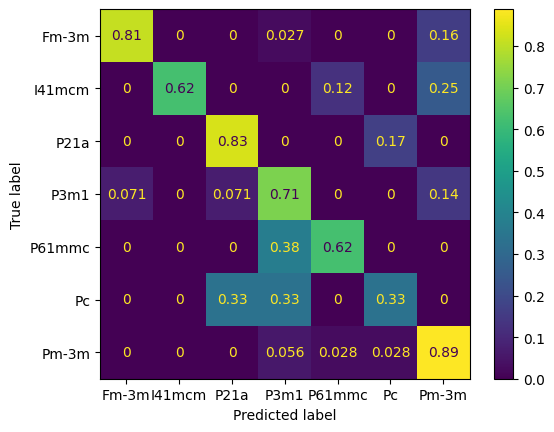

Accuracy: 0.7777777777777778


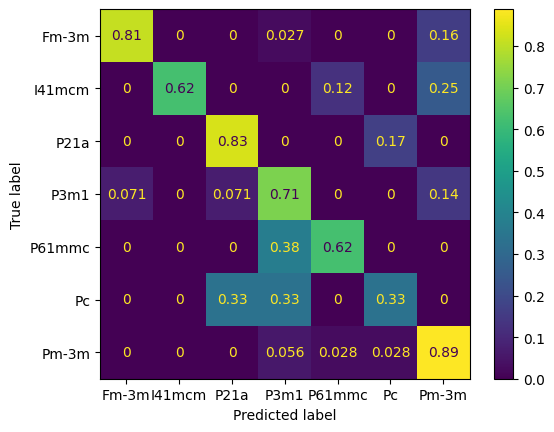

Accuracy: 0.7777777777777778


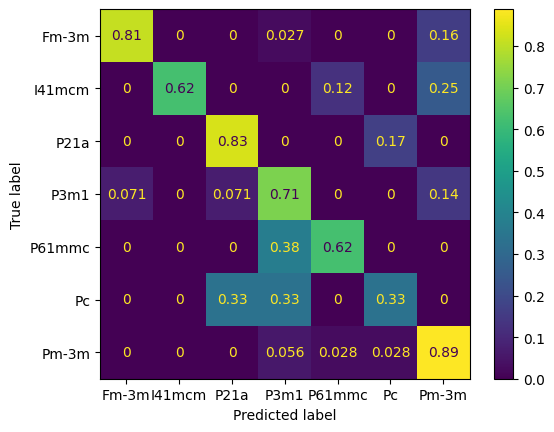

Accuracy: 0.7777777777777778


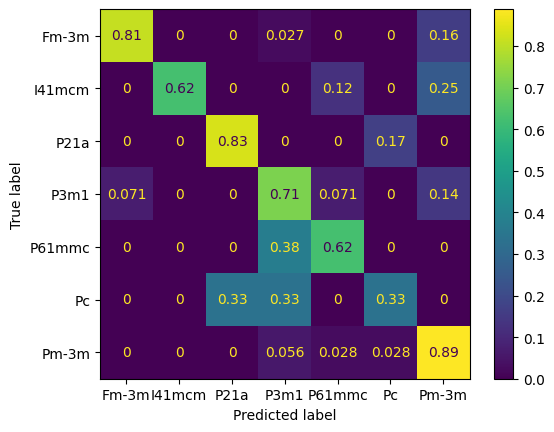

Accuracy: 0.7777777777777778


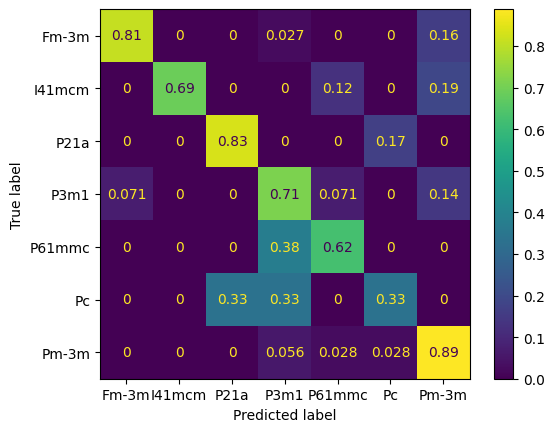

Accuracy: 0.7857142857142857


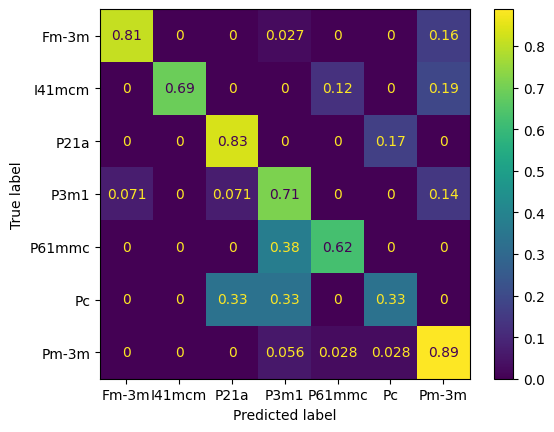

Accuracy: 0.7857142857142857


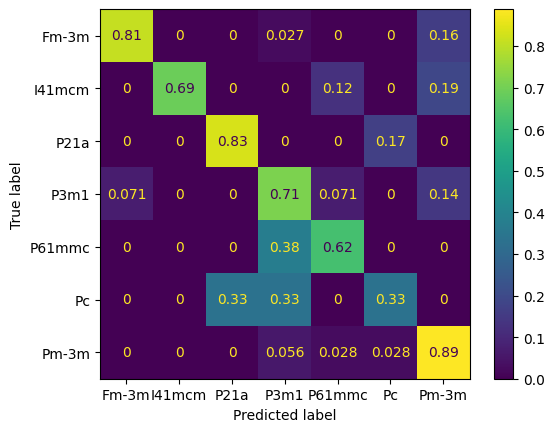

Accuracy: 0.7857142857142857


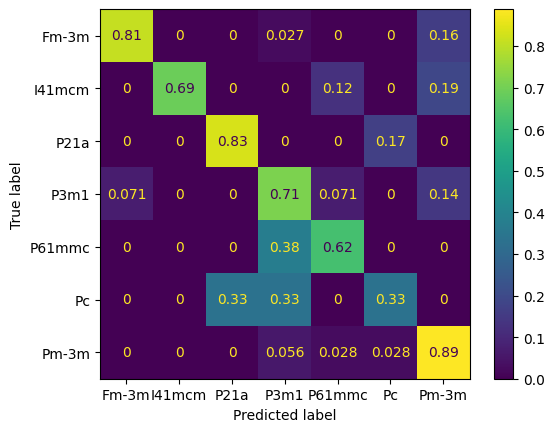

Accuracy: 0.7857142857142857


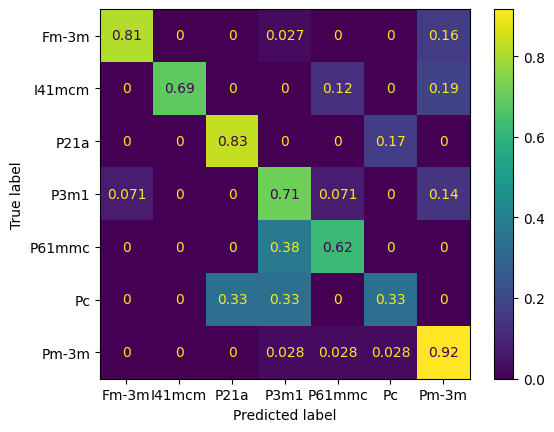

Accuracy: 0.7936507936507936


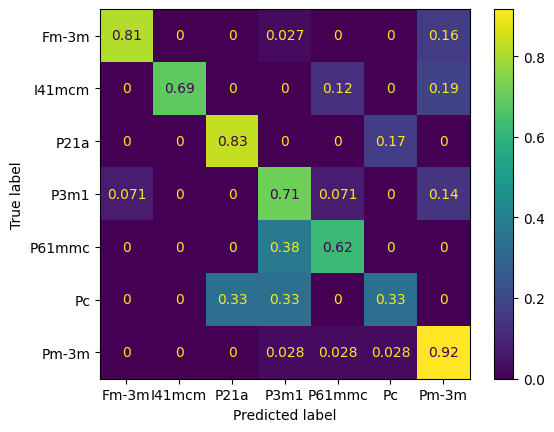

Accuracy: 0.7936507936507936


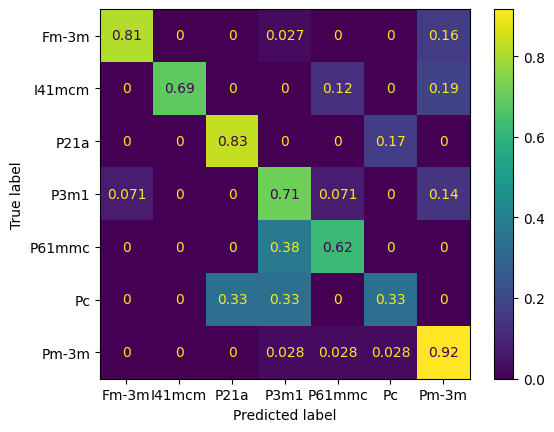

Accuracy: 0.7936507936507936


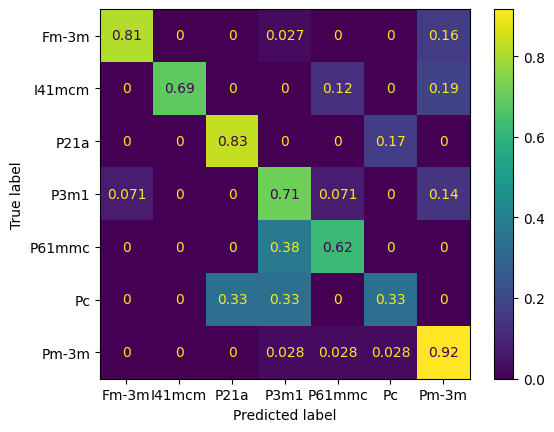

Accuracy: 0.7936507936507936


In [52]:
from sklearn.metrics import accuracy_score

rounds=np.array([2])
rounds = np.append(rounds, np.arange(5, 101, 5))
print(rounds)
accuracies = []
#for loop to test the performance of the decision tree as a function of number of rounds
for i in rounds:
    model_tree = decision_tree(train_x, train_y, i)
    dtest = xgb.DMatrix(X_test, label=y_test)

    y_pred = model_tree.predict(dtest)

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    # cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    accuracies.append(accuracy)

score = {
    'rounds': rounds,
    'accuracy': accuracies
}

score_table = pd.DataFrame(score)

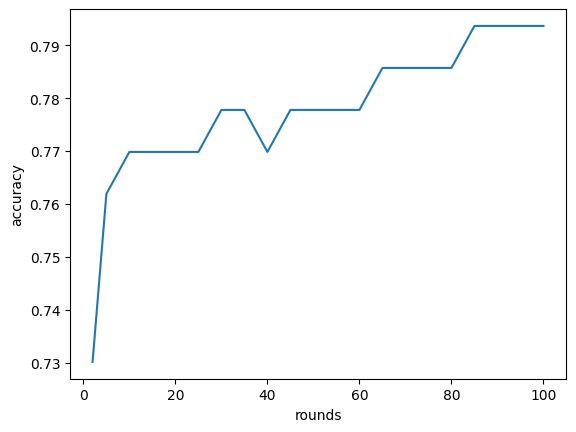

In [53]:
plt.plot(score_table['rounds'], score_table['accuracy'])
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.show()

In [54]:
max_index = np.argmax(accuracies)
max_value = accuracies[max_index]
max_rounds = rounds[max_index]
print(f"The maximum value is {max_value} at {max_rounds} rounds.")

The maximum value is 0.7936507936507936 at 85 rounds.


# F1 Hyperparameter tunning

In [13]:
!pip install -q -U keras-tuner

In [14]:
import keras_tuner as kt

##Original NN

In [15]:


def model_builder(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt')

# Perform hyperparameter search
tuner.search(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_x, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

Reloading Tuner from /content/drive/MyDrive/DLP/intro_to_kt/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - categorical_accuracy: 0.3728 - loss: 1.5742 - val_categorical_accuracy: 0.3016 - val_loss: 2.1890
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.6053 - loss: 1.0062 - val_categorical_accuracy: 0.4365 - val_loss: 1.9010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.7048 - loss: 0.7877 - val_categorical_accuracy: 0.5079 - val_loss: 1.9182
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.7656 - loss: 0.6648 - val_categorical_accuracy: 0.4762 - val_loss: 2.0109
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8170 - loss: 0.4940 - val_categorical_accuracy: 0.5556 - val_loss: 2.1278
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.8507 - loss: 0.4114 - val_categorical_accuracy: 0.5952 - val_loss: 1.7968
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.8670 - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 96)             │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 48)              │          23,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,775 (346.78 KB)

 Trainable params: 29,591 (115.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,184 (231.19 KB)

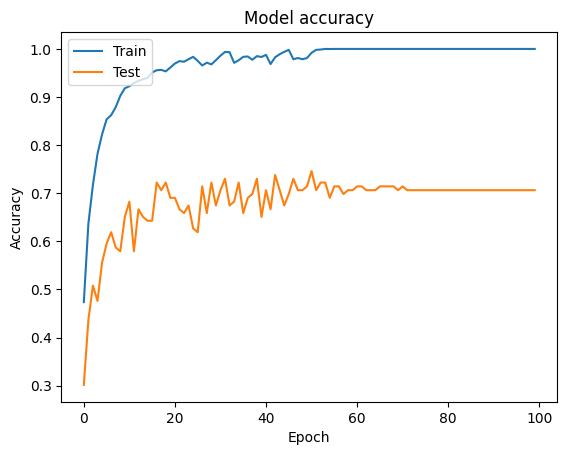

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


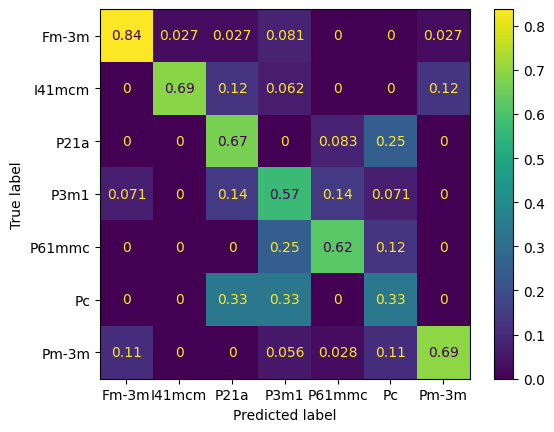

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


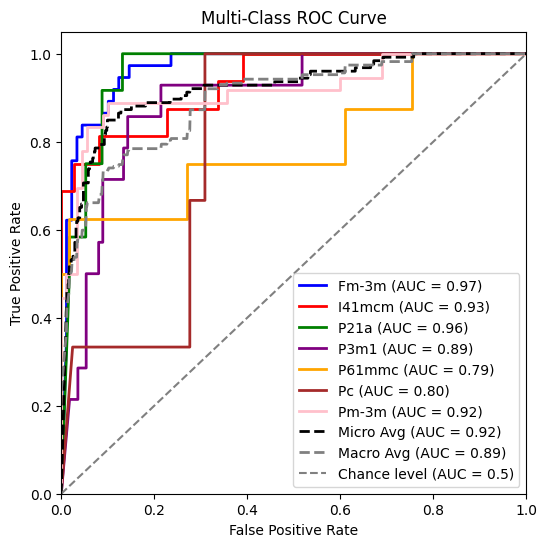

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.8611    0.8378    0.8493        37
           1     0.9167    0.6875    0.7857        16
           2     0.5714    0.6667    0.6154        12
           3     0.4706    0.5714    0.5161        14
           4     0.5556    0.6250    0.5882         8
           5     0.1000    0.3333    0.1538         3
           6     0.8929    0.6944    0.7812        36

    accuracy                         0.7063       126
   macro avg     0.6240    0.6309    0.6128       126
weighted avg     0.7687    0.7063    0.7294       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - categorical_accuracy: 0.6805 - loss: 8.0799
{'categorical_accuracy': 0.7063491940498352, 'loss': 6.576693534851074}


In [16]:
eval_model(model, hist, test_x, test_y)

##Batch normalization

In [17]:
def model_builder_batch(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))
    model.add(K.layers.BatchNormalization())

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder_batch,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_batch')

# Perform hyperparameter search
tuner.search(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_x, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

Reloading Tuner from /content/drive/MyDrive/DLP/intro_to_kt_batch/tuner0.json
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - categorical_accuracy: 0.4875 - loss: 1.3376 - val_categorical_accuracy: 0.1667 - val_loss: 1.9556
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7894 - loss: 0.5685 - val_categorical_accuracy: 0.1270 - val_loss: 2.2315
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8682 - loss: 0.3534 - val_categorical_accuracy: 0.1984 - val_loss: 2.0950
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9122 - loss: 0.2477 - val_categorical_accuracy: 0.5952 - val_loss: 1.1882
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9366 - loss: 0.1785 - val_categorical_accuracy: 0.6746 - val_loss: 1.1460
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9537 - loss: 0.1347 - val_categorical_accuracy: 0.2698 - val_loss: 3.8563
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.9573 - loss: 0.1196 - val_ca

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 150, 32)             │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 30, 48)              │           7,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 10, 48)              │           6,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,983 (183.53 KB)

 Trainable params: 15,639 (61.09 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 31,280 (122.19 KB)

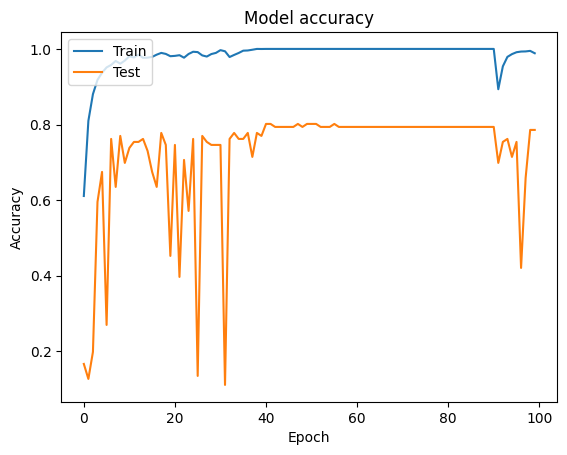

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


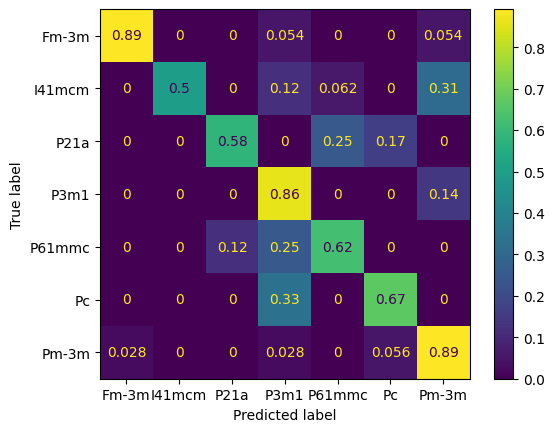

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


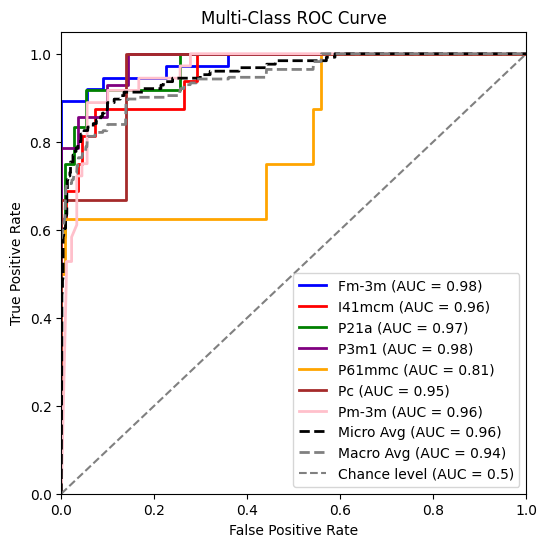

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.9706    0.8919    0.9296        37
           1     1.0000    0.5000    0.6667        16
           2     0.8750    0.5833    0.7000        12
           3     0.6000    0.8571    0.7059        14
           4     0.5556    0.6250    0.5882         8
           5     0.3333    0.6667    0.4444         3
           6     0.7805    0.8889    0.8312        36

    accuracy                         0.7857       126
   macro avg     0.7307    0.7161    0.6951       126
weighted avg     0.8282    0.7857    0.7881       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - categorical_accuracy: 0.7487 - loss: 3.7746
{'categorical_accuracy': 0.7857142686843872, 'loss': 3.221855640411377}


In [18]:
eval_model(model, hist, test_x, test_y)

##Dropout

In [19]:
def model_builder_dropout(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    # Add Dropout after the first Conv1D layer
    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout1))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Add Dropout after the second Conv1D layer (optional)
    hp_dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout2))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout3 = hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout3))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

tuner = kt.Hyperband(model_builder_dropout,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_dropout')

# Perform hyperparameter search
tuner.search(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_x, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

Reloading Tuner from /content/drive/MyDrive/DLP/intro_to_kt_dropout/tuner0.json
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.3508 - loss: 1.6276 - val_categorical_accuracy: 0.3016 - val_loss: 2.0135
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.5867 - loss: 1.1031 - val_categorical_accuracy: 0.2857 - val_loss: 2.2405
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6211 - loss: 0.9858 - val_categorical_accuracy: 0.3968 - val_loss: 1.9251
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6827 - loss: 0.8448 - val_categorical_accuracy: 0.5317 - val_loss: 1.6476
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7215 - loss: 0.7467 - val_categorical_accuracy: 0.5635 - val_loss: 1.7196
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.7546 - loss: 0.6775 - val_categorical_accuracy: 0.4921 - val_loss: 1.8385
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7658 - loss: 0.6342 - val_ca

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 150, 96)             │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 96)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 30, 48)              │          23,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 48)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 10, 48)              │           6,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 48)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,071 (375.28 KB)

 Trainable params: 32,023 (125.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,048 (250.19 KB)

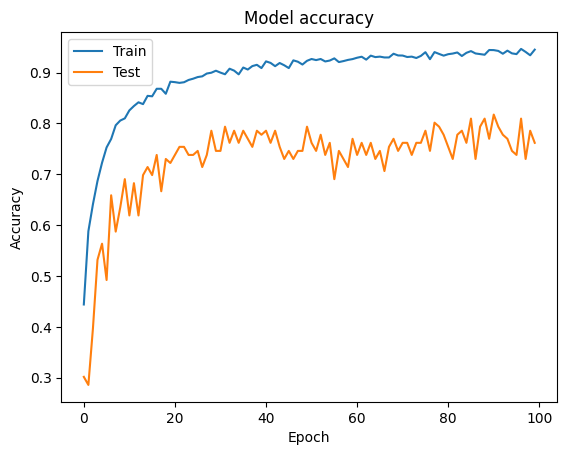

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


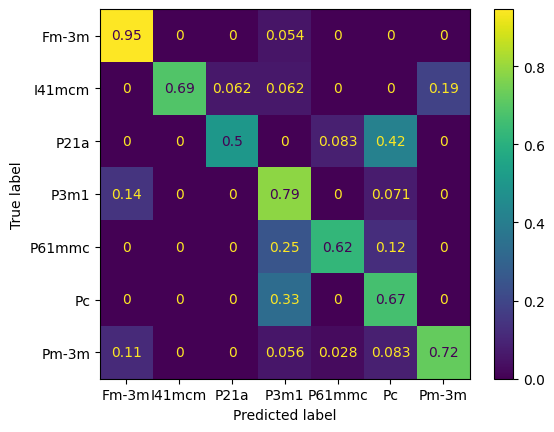

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


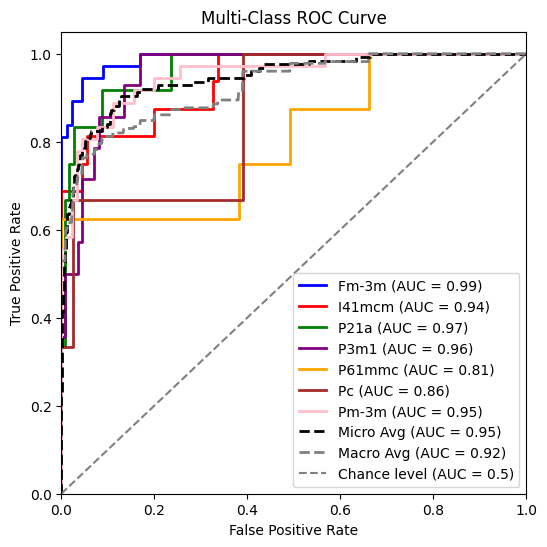

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0     0.8537    0.9459    0.8974        37
           1     1.0000    0.6875    0.8148        16
           2     0.8571    0.5000    0.6316        12
           3     0.5789    0.7857    0.6667        14
           4     0.7143    0.6250    0.6667         8
           5     0.1667    0.6667    0.2667         3
           6     0.8966    0.7222    0.8000        36

    accuracy                         0.7619       126
   macro avg     0.7239    0.7047    0.6777       126
weighted avg     0.8291    0.7619    0.7785       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - categorical_accuracy: 0.7381 - loss: 2.0996
{'categorical_accuracy': 0.761904776096344, 'loss': 1.7866601943969727}


In [20]:
eval_model(model, hist, test_x, test_y)

##Big model

In [21]:
def model_builder_big(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 150, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    model.add(K.layers.BatchNormalization())

    # Add Dropout after the first Conv1D layer
    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout1))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 30, strides=5, padding='same', activation='relu'))

    # Add Dropout after the second Conv1D layer (optional)
    hp_dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout2))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 6, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout3 = hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout3))

    # Tune the number of filters in the third Conv1D layer
    hp_units4 = hp.Int('units4', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units4, 2, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout4 = hp.Float('dropout4', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout4))

    # Tune the number of filters in the third Conv1D layer
    hp_units5 = hp.Int('units5', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units5, 1, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout5 = hp.Float('dropout5', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout5))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

tuner = kt.Hyperband(model_builder_big,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_big')

# Perform hyperparameter search
tuner.search(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_x, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

Trial 28 Complete [00h 00m 19s]
val_categorical_accuracy: 0.8095238208770752

Best val_categorical_accuracy So Far: 0.841269850730896
Total elapsed time: 00h 21m 30s
Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - categorical_accuracy: 0.5220 - loss: 1.2369 - val_categorical_accuracy: 0.4444 - val_loss: 1.5859
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8760 - loss: 0.3616 - val_categorical_accuracy: 0.3492 - val_loss: 1.6535
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9190 - loss: 0.2541 - val_categorical_accuracy: 0.6508 - val_loss: 1.6252
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9483 - loss: 0.1657 - val_categorical_accuracy: 0.7381 - val_loss: 1.1332
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9496 - loss: 0.1576 - val_categorical_accuracy: 0.7619 - val_loss: 1.4103
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 150, 32)             │           4,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 150, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 30, 64)              │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 10, 16)              │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 4, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 2, 48)               │           1,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 48)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,695 (885.53 KB)

 Trainable params: 75,543 (295.09 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 151,088 (590.19 KB)

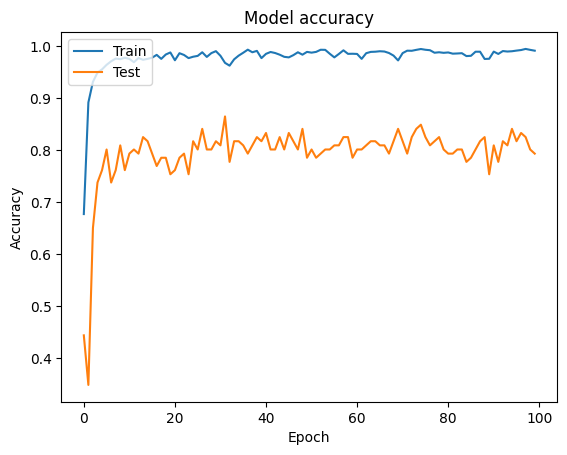

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


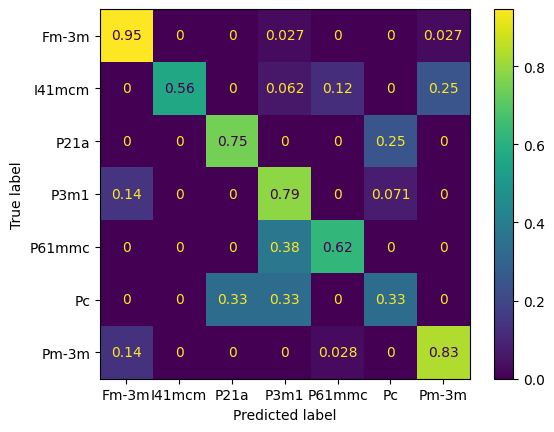

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


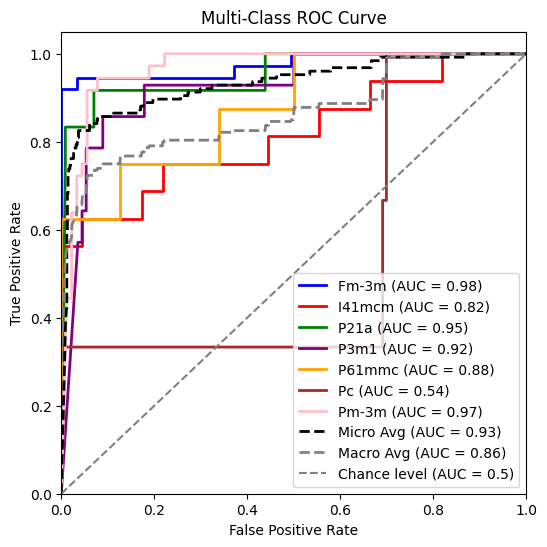

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0     0.8333    0.9459    0.8861        37
           1     1.0000    0.5625    0.7200        16
           2     0.9000    0.7500    0.8182        12
           3     0.6471    0.7857    0.7097        14
           4     0.6250    0.6250    0.6250         8
           5     0.2000    0.3333    0.2500         3
           6     0.8571    0.8333    0.8451        36

    accuracy                         0.7937       126
   macro avg     0.7232    0.6908    0.6934       126
weighted avg     0.8186    0.7937    0.7955       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - categorical_accuracy: 0.7560 - loss: 4.3234
{'categorical_accuracy': 0.7936508059501648, 'loss': 3.7269177436828613}


In [22]:
eval_model(model, hist, test_x, test_y)